In [2]:
import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
from numpy.random import randn
from IPython.display import clear_output

In [3]:
matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("Will skip plotting; matplotlib is not available.")
    matplotlib_is_available = False

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print("Using %s for computation" % device)

Using cuda for computation


In [25]:
resources = "resources/"
models = "models/"

In [5]:
def real_fn(x):
    return x*x + 3*x + 2

def get_real_samples(n=5000, scale=50):
    data = []
    x = scale * randn(n)

    for i in range(n):
        y = real_fn(x[i])
        data.append([x[i], y])

    return torch.FloatTensor(data)

In [6]:
def get_fake_samples(n=5000, elements=5):
    return torch.randn(size=[n, elements])

In [9]:
class Generator(nn.Module):
    def __init__(self, input_len=5, hidden_len=16, output_len=2):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_len, hidden_len),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_len, hidden_len),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_len, output_len)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

generator = Generator()

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_len=2, hidden_len=16, output_len=1):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_len, hidden_len),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_len, hidden_len),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(hidden_len, output_len),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

discriminator = Discriminator()

In [11]:
d_lr = 1e-3
g_lr = 1e-3
loss = nn.BCELoss()

In [12]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr)
g_optimizer = optim.Adam(generator.parameters(), lr=g_lr)

In [40]:
generator.load_state_dict(torch.load(models+'generator.pth'))
discriminator.load_state_dict(torch.load(models+'discriminator.pth'))
g_optimizer.load_state_dict(torch.load(models+'g_optimizer.pth'))
d_optimizer.load_state_dict(torch.load(models+'d_optimizer.pth'))

In [14]:
dtype = torch.cuda.FloatTensor

def ones_target(size):
#     data = Variable(torch.ones(size, 1).type(dtype))
    data = Variable(torch.Tensor(size, 1).fill_(0.9).type(dtype))
    return data


def zeros_target(size):
    data = Variable(torch.zeros(size, 1).type(dtype))
    return data

In [15]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    optimizer.zero_grad()

    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()

    optimizer.step()

    return error_real + error_fake, prediction_real, prediction_fake

In [16]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    optimizer.zero_grad()

    prediction = discriminator(fake_data)

    error = loss(prediction, ones_target(N))
    error.backward()

    optimizer.step()

    return error

In [23]:
num_test_samples = 256
discriminator_steps = 20
generator_steps = 20
num_epochs = 5000
printing_epoch = 100
discriminator.to(device)
generator.to(device)
d_losses = []
g_losses = []

In [34]:
def current_status(real, fake, epoch):
    x, y = zip(*fake.tolist())
    plt.scatter(x, y, label='Generated Data')
    x, y = zip(*real.tolist())
    plt.scatter(x, y, label='Real Data')
    plt.legend(loc='upper right')
    plt.xlabel("input")
    plt.title("Comparsion of Real vs Generated Data - Epoch %s" %epoch)
    save_location = resources+ 'epoch-%s.png' %epoch
    plt.savefig(save_location, bbox_inches='tight')
    plt.show()

def plot_losses(disc, gene):
    plt.plot(disc, label='Discriminator Loss')
    plt.plot(gene, label='Generator Loss')
    plt.legend(loc='upper right')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Discriminator and Generator Loss")
    save_location = resources+ 'loss.png'
    plt.savefig(save_location, bbox_inches='tight')
    plt.show()

Epoch
4900
Discriminator Loss:
1.374895453453064
Generator Loss:
0.7965847253799438


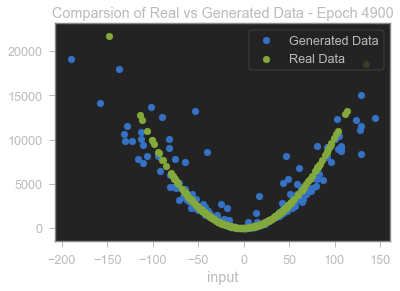

In [41]:
discriminator.train()
generator.train()
for epoch in range(num_epochs):
    real_data = None
    fake_data = None
    
    for d_steps in range(discriminator_steps):
        real_data = get_real_samples(n=num_test_samples)
        fake = get_fake_samples(n=num_test_samples)
        fake = fake.to(device)
        fake_data = generator(fake).detach()
        fake_data = fake_data.to(device)
        real_data = real_data.to(device)
        d_error, d_pred_real, d_pred_fake = \
            train_discriminator(
                d_optimizer, real_data, fake_data)
        d_losses.append(d_error.item())
    
    for g_steps in range(generator_steps):
        fake = get_fake_samples(n=num_test_samples)
        fake = fake.to(device)
        fake_data = generator(fake)
        g_error = train_generator(g_optimizer, fake_data)
        g_losses.append(g_error.item())
    
    if(epoch % printing_epoch == 0):
        clear_output()
        print("Epoch")
        print(epoch)
        print("Discriminator Loss:")
        print(d_error.item())
        print("Generator Loss:")
        print(g_error.item())
        current_status(real_data, fake_data, epoch)

In [43]:
torch.save(generator.state_dict(), models+'generator.pth')
torch.save(discriminator.state_dict(), models+'discriminator.pth')
torch.save(g_optimizer.state_dict(), models+'g_optimizer.pth')
torch.save(d_optimizer.state_dict(), models+'d_optimizer.pth')

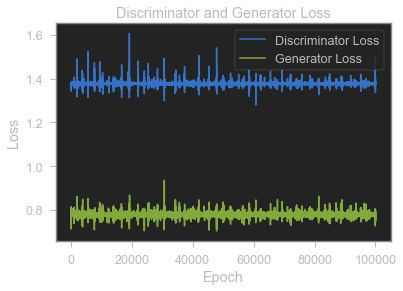

In [42]:
plot_losses(d_losses, g_losses)